# Redes Neurais - Projeto 3
# Modelos Generativos - Autoencoders Variacionais
---------------------
### Luis Filipe Menezes
#### RA: 164924

## 1. Objetivos:
Este caderno consiste na terceira entrega da disciplina de Redes Neurais realizada no programa de Pós Graduação em Ciência da Computação durante meu mestrado.

O projeto tem como objetivo:

- Selecionar 2 datasets (rotulados)

  - Treinar modelos VAEs:
  
  - Ajustar o melhor modelo (topologia) segundo a função de custo (conjunto validação)


- Explorar o espaço latente:

  - Gerar gráficos com a projeção do espaço latente em 2D (PCA)

  - Usar os rótulos na projeção.

- Algumas questões:

  1. Há formação de clusters no espaço latente?
  
  2. Há separação dos rótulos no espaço latente?
  
  3. A projeção ilustra quanto da variância?

- Adicional (opcional): Enviesar a formação do espaço latente com os exemplos rotulados


Além disso, tentarei utilizar o PyTorch nesse projeto. A implementação será feita se baseando neste [material](https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/08-deep-autoencoders.html) e nesta outra implementação de [autoencoder com MLP](https://debuggercafe.com/implementing-deep-autoencoder-in-pytorch/).

Como o modelo que ele apresenta utiliza uma CNN no dataset Ciphar, como ainda não foi estudado CNNs irei utilizar uma MLP no dataset Fashion MNIST.


### Bibliotecas utilizadas:

In [1]:
!pip install --quiet pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 61.6 MB/s eta 0:00:00


In [2]:
from torchvision.datasets import FashionMNIST
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchvision import transforms

## Dataset utilizado (Fashion MNIST)

#### Setup do sistema para garantir reprodutibilidade

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
pl.seed_everything(24)

INFO:lightning_fabric.utilities.seed:Seed set to 24


24

In [5]:
NUM_EPOCHS = 500
BATCH_SIZE = 256
LEARNING_RATE = 1e-3
LATENT_DIM = 2
INPUT_DIM = 28 * 28

In [6]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = FashionMNIST(root='./FMNIST_data', train=True, download=True, transform=transform)


100%|██████████| 26.4M/26.4M [00:01<00:00, 13.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.75MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.0MB/s]


In [7]:
test_dataset = FashionMNIST(root='./FMNIST_data', train=False, download=True, transform=transform)

In [8]:
train_set, val_set = torch.utils.data.random_split(train_dataset, [45000, 15000])


In [9]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, num_workers=2)

In [10]:
from torchvision.utils import save_image
import os

# utility functions
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
def make_dir():
    image_dir = 'FashionMNIST_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
def save_decoded_image(img, epoch):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, './FashionMNIST_Images/linear_ae_image{}.png'.format(epoch))

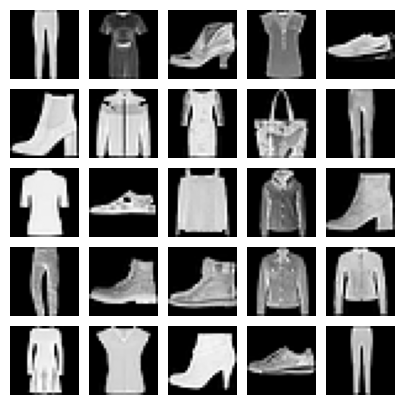

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

## Modelo em PyTorch

In [53]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim1=400, hidden_dim2=200, latent_dim=50, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.GELU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.GELU(),
            nn.Linear(hidden_dim2, latent_dim),
            nn.GELU()
            )

        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.GELU(),
            nn.Linear(latent_dim, hidden_dim2),
            nn.GELU(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.GELU(),
            nn.Linear(hidden_dim1, input_dim),
            nn.Sigmoid()
            )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.decode(z)
        return x_hat, mean, log_var

In [54]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [55]:
model = VAE().to(device)
from torch.optim import Adam
optimizer = Adam(model.parameters(), lr=1e-3)

In [56]:
def train(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(BATCH_SIZE, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*BATCH_SIZE))
    return overall_loss

In [57]:
train(model, optimizer, epochs=50, device=device)

	Epoch 1 	Average Loss:  330.7257572919473
	Epoch 2 	Average Loss:  277.9849413290791
	Epoch 3 	Average Loss:  271.8683027947086
	Epoch 4 	Average Loss:  267.25490964692216
	Epoch 5 	Average Loss:  264.84431238284054
	Epoch 6 	Average Loss:  263.6590848900806
	Epoch 7 	Average Loss:  262.45311149509473
	Epoch 8 	Average Loss:  261.73010017131935
	Epoch 9 	Average Loss:  261.341227827401
	Epoch 10 	Average Loss:  260.67570977923515
	Epoch 11 	Average Loss:  260.01201278861913
	Epoch 12 	Average Loss:  259.31434736580684
	Epoch 13 	Average Loss:  259.08709471253144
	Epoch 14 	Average Loss:  259.53900050020764
	Epoch 15 	Average Loss:  258.91135011870284
	Epoch 16 	Average Loss:  258.14788020342246
	Epoch 17 	Average Loss:  258.63977436635685
	Epoch 18 	Average Loss:  257.8632230210578
	Epoch 19 	Average Loss:  257.294410530178
	Epoch 20 	Average Loss:  256.82286782100283
	Epoch 21 	Average Loss:  256.558318214855
	Epoch 22 	Average Loss:  256.1968753858544
	Epoch 23 	Average Loss:  256.0

11260812.18359375

In [58]:
def gen_fashion(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    fashion = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.title(f'[{mean},{var}]')
    plt.imshow(fashion, cmap='gray')
    plt.axis('off')
    plt.show()

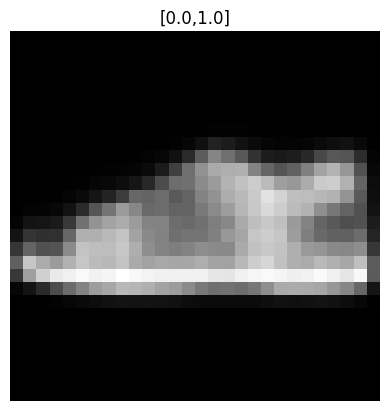

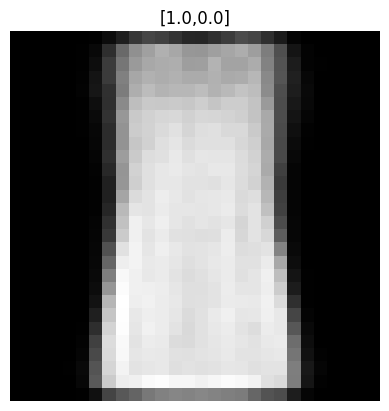

(None, None)

In [59]:
gen_fashion(0.0, 1.0), gen_fashion(1.0, 0.0)

In [60]:
import numpy as np

def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

/tmp/ipython-input-805313110.py:16: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit


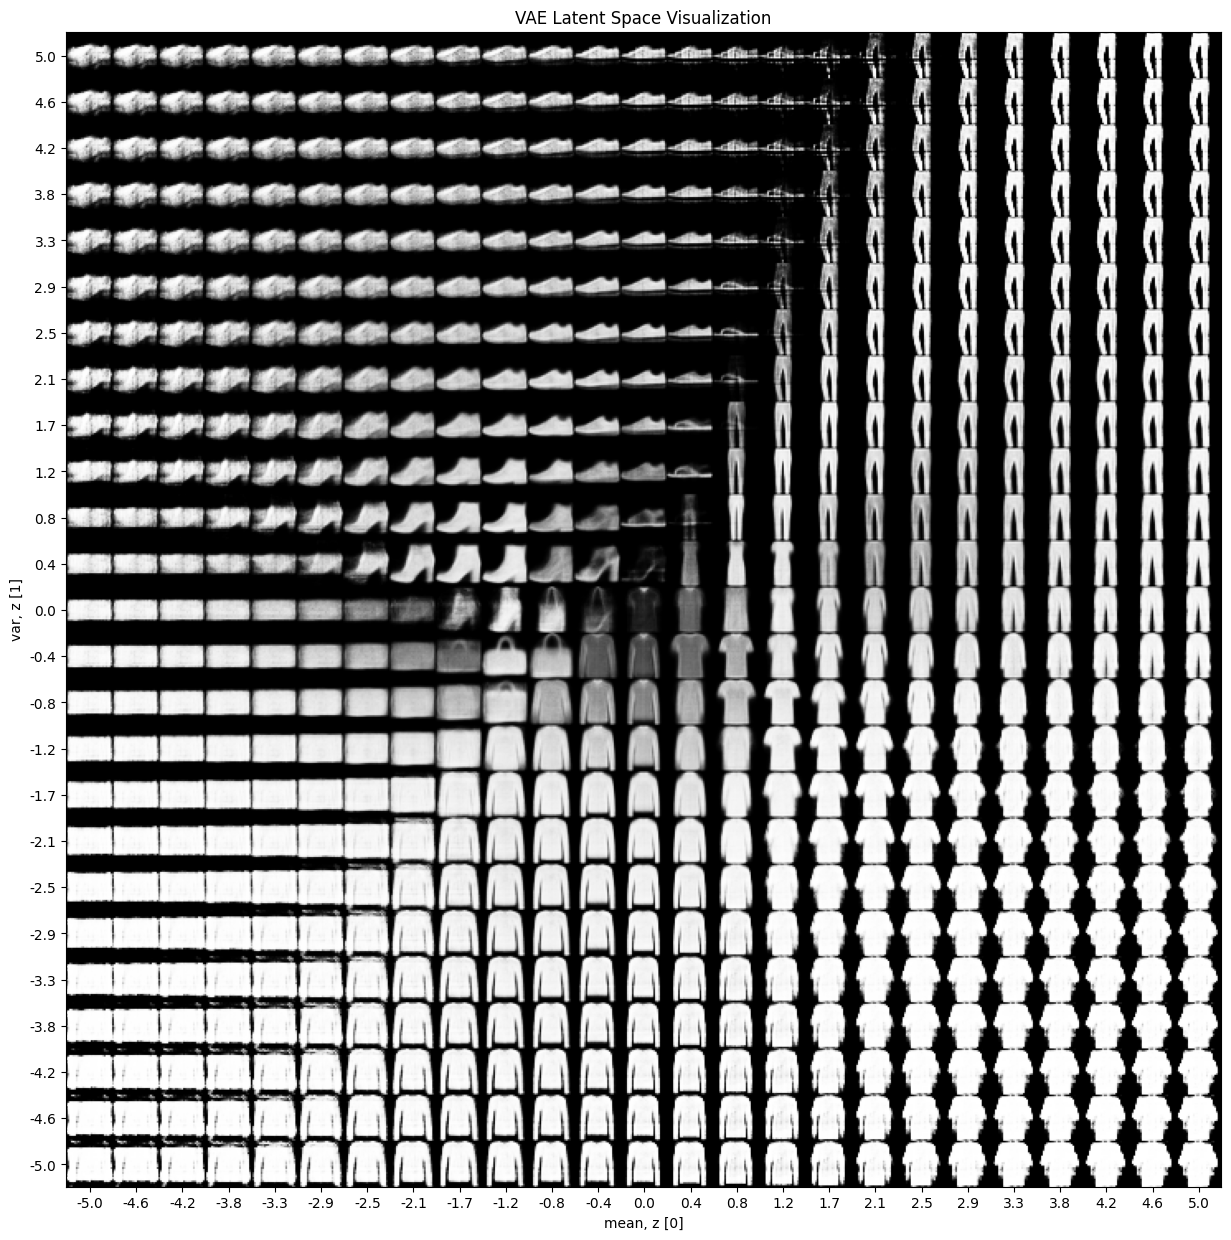

In [62]:
plot_latent_space(model, scale=5.0)